# Raw Loss Plots

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
#mpl.use('pdf')
import sys
sys.path.append("../")
import copy
from Plotting.generate_database import ResultsDatabaseGenerator
from common_packages.utilities import get_equivalent_classical_layer_size, get_num_parameters_per_quantum_layer
from Plotting.Plot import BasicPlot, MultiPlot
import pandas as pd
import seaborn as sns
colors =   ["#5dd448",
            "#bfa900",
            "#ec742f",
            "#e9496f",
            "#b04ca4",]

colors = ["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=colors)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 0.5



2023-08-18 11:26:47.654677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib64:
2023-08-18 11:26:47.654767: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


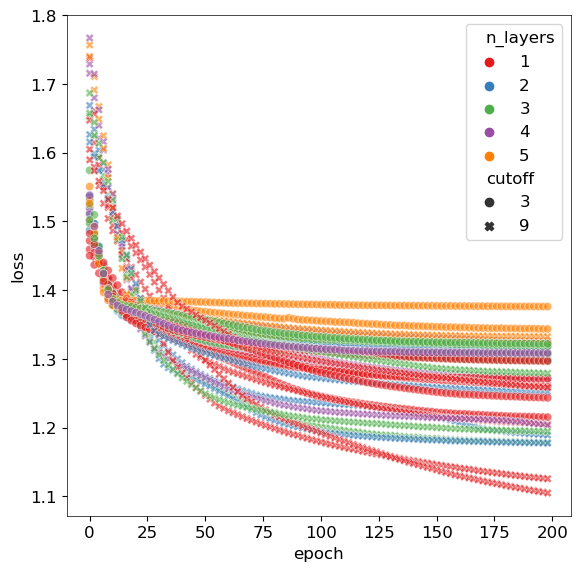

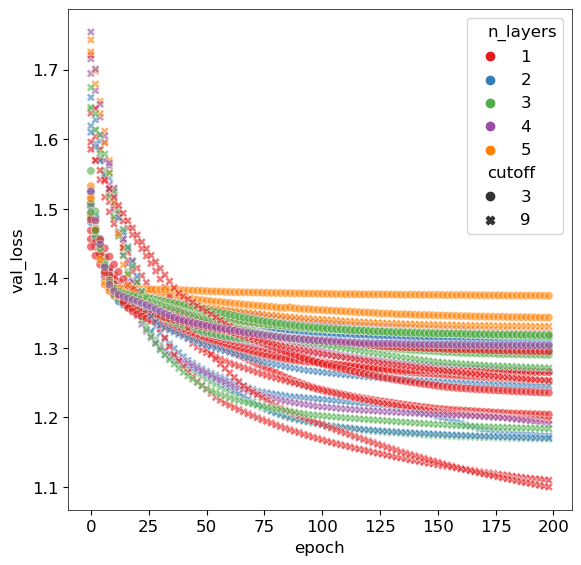

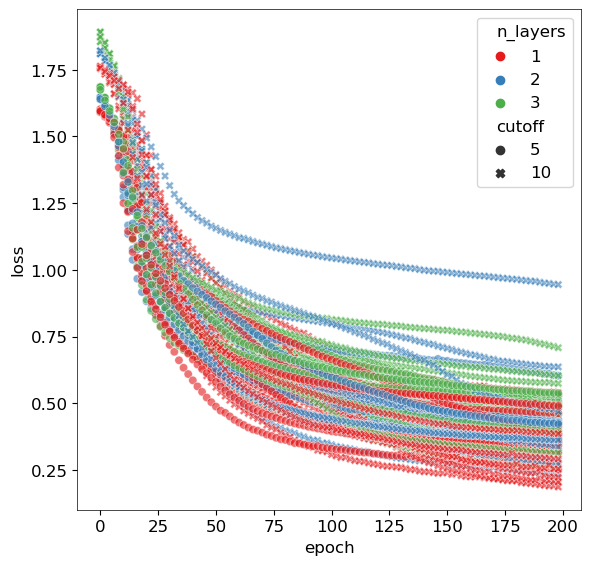

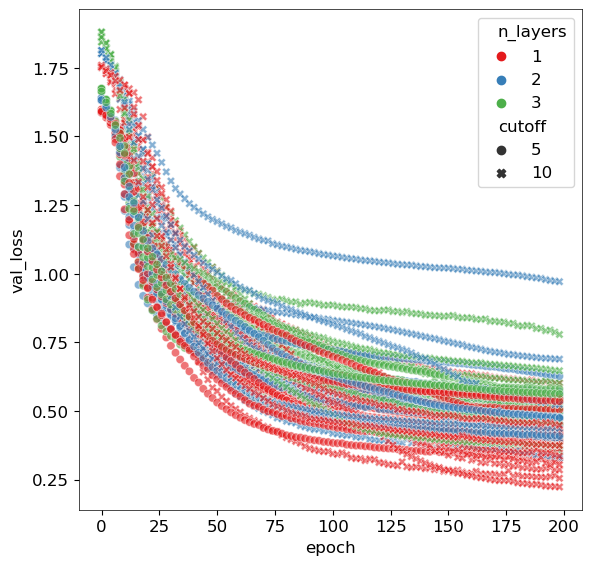

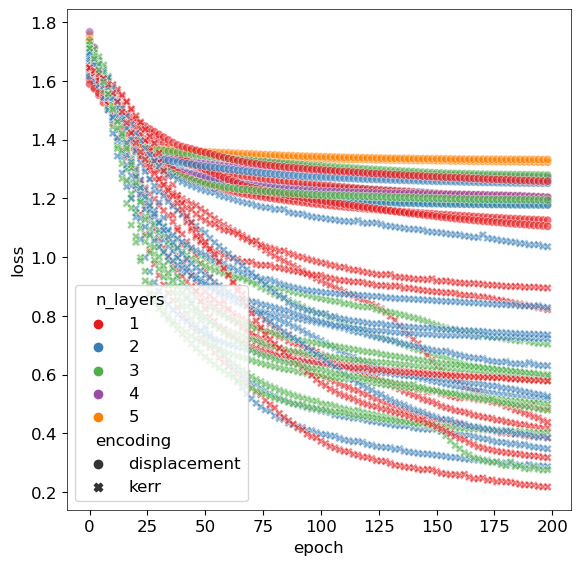

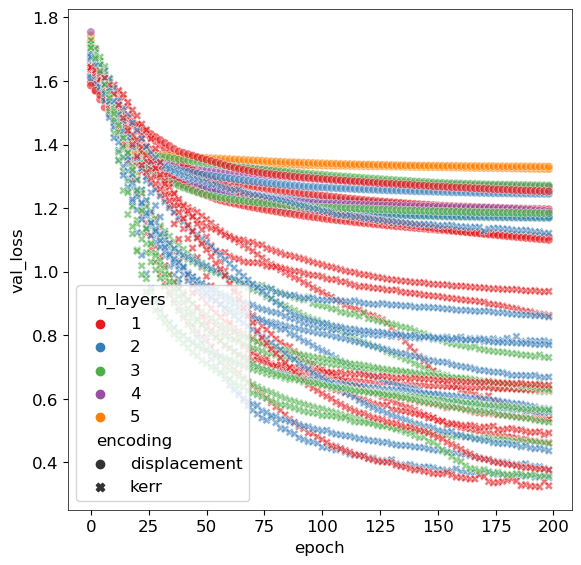

In [9]:
def plot_raw_data(df, metrics=['loss', 'val_loss'], 
                  hue='network_type', 
                  style='num_qumodes', 
):
    for metric in metrics:
        fig, ax = plt.subplots(1,1, figsize=(6.5, 6.5))
        sns.scatterplot(df, x='epoch', y=metric, hue=hue, style=style, alpha=0.6, markers=True, palette='Set1')
         

df = pd.read_pickle('df_full.pkl')
df['epoch'] = [np.arange(0,200,1) for i, row in df.iterrows()]
df_exp = df.explode(column=['acc', 'val_acc', 'loss', 'val_loss', 'epoch'])
df_exp.reset_index(inplace=True)
df_exp.pop('index')
df_exp.drop(df_exp.loc[(df_exp['epoch'] % 2 != 0)].index, inplace=True)
df_exp.loc[df_exp['cutoff'] == 'classical','cutoff'] = -1
df_exp['loss'] = df_exp['loss']

df_plotd = df_exp.loc[(df_exp['encoding']=='displacement') & 
                      (df_exp['network_type'] == 'quantum')&
                      (df_exp['num_qumodes'] == 2) & 
                      (df_exp['cutoff'] % 3 == 0)]
df_plotk = df_exp.loc[(df_exp['encoding']=='kerr') & 
                      (df_exp['network_type'] == 'quantum') &
                      (df_exp['num_qumodes'] == 3)  
                      ]
df_plotf = df_exp.loc[(df_exp['num_qumodes'] == 2) &
                      ((df_exp['cutoff'] == 9) | (df_exp['cutoff'] == 10)) 
                      ]
plot_raw_data(df_plotd, hue='n_layers', style='cutoff')
plot_raw_data(df_plotk, hue='n_layers', style='cutoff')
plot_raw_data(df_plotf, hue='n_layers', style='encoding')